In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [119]:
tags = pd.DataFrame(columns = ['chrom', 'str_pos', 'snp_pos', 'LD'])
for i in range(10):
    df = pd.read_csv(f"chr21_{i}_tag_info.txt", sep = "\t", header = None)
    df.columns = ['chrom', 'str_pos', 'snp_pos', 'LD']
    tags = pd.concat([tags,df])
tags['abs_LD'] = tags['LD'].abs()
tags.to_csv("SNP_tags_chr21.csv", sep=",", index=False)

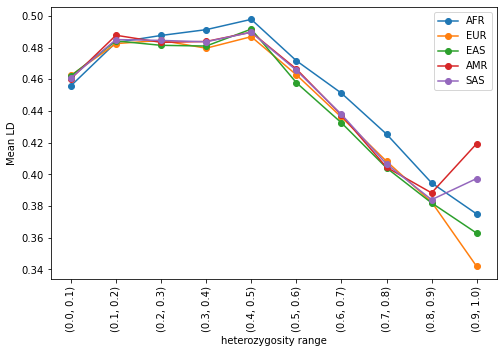

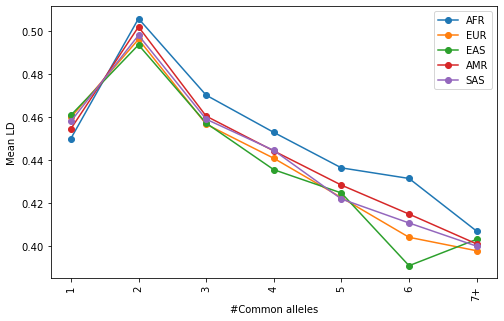

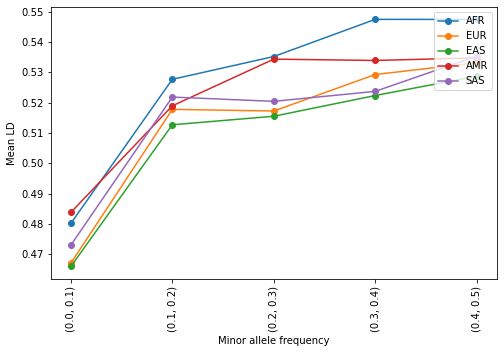

In [118]:
def common_alleles(afreqs):
    if afreqs == ".":
        return np.nan
    afreqs = afreqs.split(",")
    cnt = 0
    for afreq in afreqs:
        if float(afreq.split(":")[1]) > 0.01:
            cnt += 1   
    return cnt

def minor_allele(afreqs):
    if afreqs == ".":
        return np.nan
    afreqs = afreqs.split(",")
    cnt = 0
    if len(afreqs) == 2:
        freq1 = float(afreqs[0].split(":")[1])
        freq2 = float(afreqs[1].split(":")[1])
        return min(freq1, freq2)
    return np.nan  

pops = ['AFR', 'EUR', 'EAS', 'AMR', 'SAS']

fig, ax = plt.subplots(figsize=(8, 5))
fig2, ax2 = plt.subplots(figsize=(8, 5))
fig3, ax3 = plt.subplots(figsize=(8, 5))


keys = []
for i in range(10):
    keys.append((i/10,(i+1)/10))
    
    
ma_keys = []
for i in range(5):
    ma_keys.append((i/10,(i+1)/10))
for i in range(len(pops)):
    pop = pops[i]
    
    stats = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/allele_freq/freqs/freqs_chr21_{pop}.tab", 
                        sep = "\t")
    stats.drop_duplicates(subset=['chrom','start'])
    stats['chrom'] = stats['chrom'].astype(str)
    stats['common_alleles'] = stats.apply(lambda x: common_alleles(x['afreq-1']), axis = 1)
    stats['minor_allele'] = stats.apply(lambda x: minor_allele(x['afreq-1']), axis = 1)

    stats_tags = pd.merge(stats, tags, left_on = ['chrom','start'], right_on = ['chrom', 'str_pos'])
    stats_tags_grouped = stats_tags.groupby("common_alleles", as_index=False).agg({'abs_LD': np.mean})
    plus_7 = np.mean(stats_tags[stats_tags['common_alleles'] > 6]['abs_LD'])
    stats_tags_grouped = stats_tags_grouped[stats_tags_grouped['common_alleles'] < 7]
    stats_tags_grouped.loc[len(stats_tags_grouped.index)] = [7, plus_7] 
    het_dict = {}
    for i in range(10):
        het_dict[i] = []
        
    for index,row in stats_tags.iterrows():
        het_dict[int(row['het-1'] * 10)].append(row['abs_LD'])
        
    for key in het_dict:
        het_dict[key] = np.nanmean(het_dict[key])  
        

    minor_allele_dict = {}
    for i in range(5):
        minor_allele_dict[i] = []

    for index,row in stats_tags.iterrows():
        if ~np.isnan(row['minor_allele']):
            minor_allele_dict[min(int(row['minor_allele'] * 10),4)].append(row['abs_LD'])

    for key in minor_allele_dict:
        minor_allele_dict[key] = np.nanmean(minor_allele_dict[key])  
        
    
    ax.plot(het_dict.keys(), het_dict.values(), marker= "o", label = pop)
    ax2.plot(stats_tags_grouped.common_alleles, stats_tags_grouped.abs_LD, marker= "o", label = pop)
    ax3.plot(minor_allele_dict.keys(), minor_allele_dict.values(), marker= "o", label = pop) 
    
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xticklabels(keys,rotation='vertical')
ax.set_ylabel("Mean LD")
ax.set_xlabel("heterozygosity range")
ax.legend(loc="upper right")  

ax2.xaxis.set_ticks(np.arange(1, 8, 1))
ax2.set_xticklabels([str(x) for x in np.arange(1, 7, 1)] + ["7+"] ,rotation='vertical')
ax2.set_ylabel("Mean LD")
ax2.set_xlabel("#Common alleles")
ax2.legend(loc="upper right")  

   
ax3.xaxis.set_ticks(np.arange(0, 5, 1))
ax3.set_xticklabels(ma_keys,rotation='vertical')
ax3.set_ylabel("Mean LD")
ax3.set_xlabel("Minor allele frequency")
ax3.legend(loc="upper right") 

Text(0, 0.5, '#SNP tags')

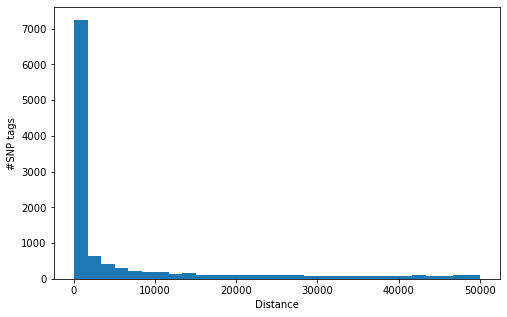

In [85]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist((tags['snp_pos'] - tags['str_pos']).abs(), bins=30)
ax.set_xlabel("Distance")
ax.set_ylabel("#SNP tags")

[Text(1, 0, '(0.0, 0.1)'),
 Text(2, 0, '(0.1, 0.2)'),
 Text(3, 0, '(0.2, 0.3)'),
 Text(4, 0, '(0.3, 0.4)'),
 Text(5, 0, '(0.4, 0.5)'),
 Text(6, 0, '(0.5, 0.6)'),
 Text(7, 0, '(0.6, 0.7)'),
 Text(8, 0, '(0.7, 0.8)'),
 Text(9, 0, '(0.8, 0.9)'),
 Text(10, 0, '(0.9, 1.0)'),
 Text(11, 0, '(1.0, 1.1)')]

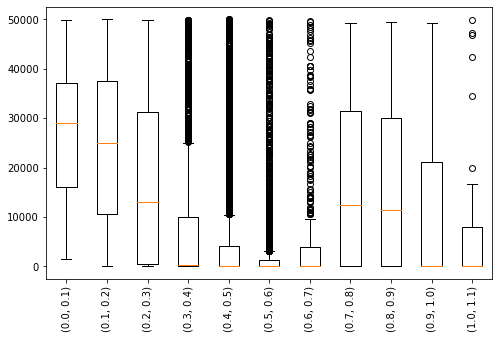

In [99]:
keys = []
for i in range(11):
    keys.append((i/10,(i+1)/10))
dist_dict = {}
for i in range(11):
    dist_dict[i] = []

for index,row in tags.iterrows():
    if ~np.isnan(row['abs_LD']):
        dist_dict[int(row['abs_LD'] * 10)].append(abs(row['str_pos'] - row['snp_pos']))
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(dist_dict.values())
ax.set_xticklabels(keys,rotation='vertical')